<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/Toronto_FloorSpaceTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze Residential Floor Space Trends

 

## Table of Contents
- [Introduction](#intro)
- [Part I - ](#partone)
- [Part II - ](#parttwo)
- [Part III - ](#partthree)


<a id='intro'></a>
### Introduction
 


<a id='partone'></a>
### Part I - Setup

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

%matplotlib inline

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Mounted at /content/gdrive


In [3]:
# Load csv files
base_dir =  "/content/gdrive/My Drive/Colab Notebooks/SSG/Toronto_2023/"

# all buildings
file = base_dir + "df_all_bldgs.csv"
df1 = pd.read_csv(file)

# floorspace
file = base_dir + "df_all_floorspace.csv"
df2= pd.read_csv(file) 

# units
file = base_dir + "df_all_units.csv"
df3 = pd.read_csv(file) 

# we can merge into one dataframe
df = pd.merge(df1, df2,  how='inner',  on=['ID_TAZ','buildingClass','yearbuiltClass'])
df = pd.merge(df, df3, how = 'inner', on = ['ID_TAZ','buildingClass','yearbuiltClass'])

<a id=parttwo></a>
### Part II - Organizing data

In [4]:
# Do any of the rows have missing values?
df.info()

# Create some new columns

# Create a floorSpcPerUnit_sf (floorspace for a dwelling unit)
df['floorSpcPerUnit_sf'] = df['floorSpc_sf'] # by default it is the same as floor space (i.e., for detached and double detached)
df.loc[df['buildingClass'].isin(['Apt_13AndUpStorey', 'Apt_1To3Storey', 'Apt_4To6Storey','Apt_7To12Storey']) ,'floorSpcPerUnit_sf']  = df['floorSpc_sf']/df['numUnits'] #exception is for apartment buildings 

# Drop TAZ and numBldgs column (not relevant)
df.drop(['ID_TAZ','numBldgs'],
  axis='columns', inplace=True)

# Notice for all the detached building classes the floorSpc_sf is ALREADY PER UNIT (unlike for other building classes)
df.loc[df['yearbuiltClass'] > 1960] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16890 entries, 0 to 16889
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_TAZ          16890 non-null  int64  
 1   buildingClass   16890 non-null  object 
 2   yearbuiltClass  16890 non-null  int64  
 3   numBldgs        16890 non-null  float64
 4   floorSpc_sf     16890 non-null  float64
 5   numUnits        16890 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 923.7+ KB


,buildingClass,yearbuiltClass,floorSpc_sf,numUnits,floorSpcPerUnit_sf
0,Single_detached_large,2001,4116.000000,1.0,4116.000000
1,Single_detached_medium,2001,2894.401869,107.0,2894.401869
2,Single_detached_medium,2006,2581.378378,37.0,2581.378378
3,Single_detached_medium,2011,2830.666667,3.0,2830.666667
4,Single_detached_small,2001,2461.710145,69.0,2461.710145
...,...,...,...,...,...
16884,Apt_7To12Storey,2011,70775.000000,86.0,822.965116
16885,Apt_7To12Storey,2016,61904.000000,87.0,711.540230
16886,Apt_13AndUpStorey,1986,178800.000000,149.0,1200.000000
16888,Apt_1To3Storey,1971,2573.000000,6.0,428.833333


We care about the average size of the unit over time for a given buildingClass...



In [5]:
#Groupby Building Class and Year, get averages for floorspace per unit

grouped_df = df.groupby(['buildingClass', 'yearbuiltClass']).agg(TotalFloorSpc=('floorSpc_sf','sum'), 
                                            totalUnits= ('numUnits','sum'),
                                            averageFloorSpcPerUnit=('floorSpcPerUnit_sf','mean'))


grouped_df.head(300)

TotalFloorSpc  ...  averageFloorSpcPerUnit
buildingClass         yearbuiltClass                 ...                        
Apt_13AndUpStorey     1956             3.264000e+05  ...             1200.000000
                      1961             6.365400e+06  ...             1080.000000
                      1966             2.453858e+07  ...              913.111346
                      1971             3.535745e+07  ...              804.312831
                      1976             3.279149e+07  ...              780.716128
...                                             ...  ...                     ...
Single_detached_small 1996             2.266308e+05  ...             1798.657238
                      2001             3.019246e+05  ...             1863.731893
                      2006             3.194906e+05  ...             1901.729893
                      2011             3.290260e+05  ...             2006.256102
                      2016             3.240331e+05  ...             2037.943879

[153 rows x 3 columns]

In [6]:
# get rid of multi-index
grouped_df.columns = grouped_df.columns.map(lambda x: x[1]) 
grouped_df = grouped_df.reset_index() 
grouped_df.columns = ['buildingClass', 'yearbuiltClass','TotalFloorSpc','TotalUnits','AverageFloorSpace_perUnit']

# How many building classes are there?
#grouped_df['buildingClass'].unique()

<a id='partthree'></a>
### Part III- Averages

In [ ]:
# What is the year over year average, for all building types?

# Compute proportion of total floor space
sum_floorSpace = grouped_df['TotalFloorSpc'].sum()
grouped_df['propFloorSpc'] = (grouped_df['TotalFloorSpc'] / sum_floorSpace)
grouped_df.head(200)

# grouped by year and summed
result_by_year = grouped_df.groupby('yearbuiltClass').sum().reset_index()

# floorSpace_perUnit weighted by the proporation of TotalFloorSpc
# need to sum each (average floorspace x proportion) 
result_by_year['weightedAverFloorSpc'] = (result_by_year['AverageFloorSpace_perUnit']*result_by_year['propFloorSpc'])

result_by_year[['yearbuiltClass','propFloorSpc','weightedAverFloorSpc']]

In [ ]:
grouped_df

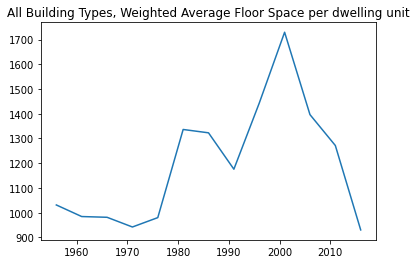

In [32]:
# within each year class, 
# get proportion of that building type's floorspace total to year's total, multiply by average floor space....sum it all up

 # create separate dataframes called yearBuilt[i] 
yearBuilt = {i: x for i, (_, x) in enumerate(grouped_df.groupby('yearbuiltClass'), 0)}

# find weighted overall average dwelling size for each year
yrs = []
ave = []
 
for i in range(len(yearBuilt)):
  total = yearBuilt[i].TotalFloorSpc.sum()
  yearBuilt[i]['weightedAve'] = (yearBuilt[i].TotalFloorSpc*yearBuilt[i].AverageFloorSpace_perUnit)/total
  yrs.append(yearBuilt[i].yearbuiltClass.mean())
  ave.append(yearBuilt[i].weightedAve.sum())


# Plot Weighted Average
fig,ax = plt.subplots(1)
ax.plot(yrs[1:14] ,ave[1:14]);
ax.set_title('All Building Types, Weighted Average Floor Space per dwelling unit');
plt.show();

In [ ]:
 #format year to datetime object
grouped_df['yearbuiltClass'] = pd.to_datetime(grouped_df['yearbuiltClass'].astype(str), format="%Y")

In [38]:
 # Next, plot each bulding class's floorSpacePerUnit across the years against it's average

# first create separate dataframes called dwelling[i] 
dwelling = {i: x for i, (_, x) in enumerate(grouped_df.groupby('buildingClass'), 0)}

# start with j = 5
j=5

dwelling[j]

,buildingClass,yearbuiltClass,TotalFloorSpc,TotalUnits,AverageFloorSpace_perUnit,propFloorSpc
69,Double_detached_small,1951,398188.130004,7329.0,1961.517882,0.001013
70,Double_detached_small,1956,161766.288063,1040.0,1348.052401,0.000411
71,Double_detached_small,1961,254369.439355,2241.0,1630.573329,0.000647
72,Double_detached_small,1966,267255.999010,1708.0,2323.965209,0.000680
73,Double_detached_small,1971,191104.408141,657.0,2275.052478,0.000486
74,Double_detached_small,1976,191890.045301,869.0,2257.529945,0.000488
75,Double_detached_small,1981,164934.814155,542.0,2425.511973,0.000419
76,Double_detached_small,1986,87615.447619,146.0,2190.386190,0.000223
77,Double_detached_small,1991,71212.450000,122.0,1874.011842,0.000181
78,Double_detached_small,1996,40602.416667,76.0,1765.322464,0.000103


<a id='partfour'></a>
### Part IV- Plots

<Figure size 432x288 with 0 Axes>

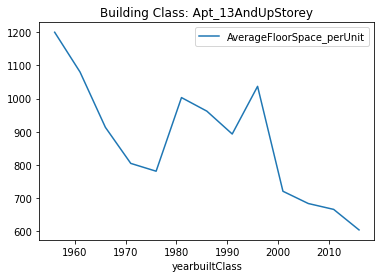

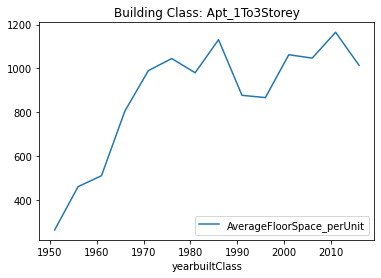

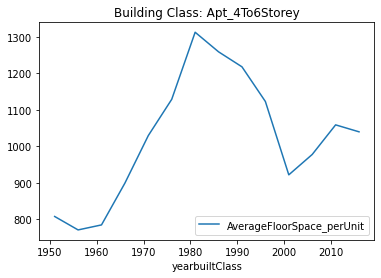

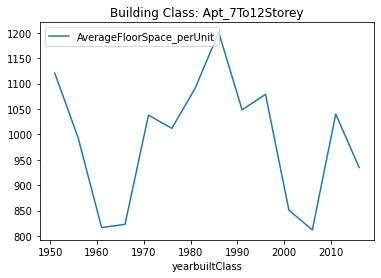

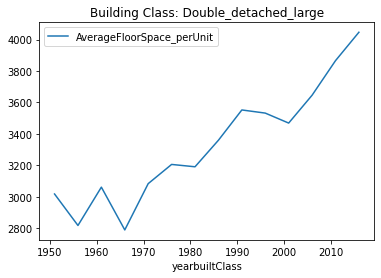

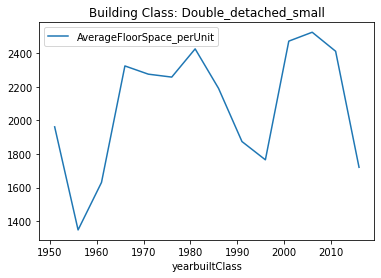

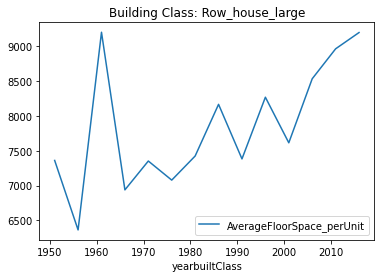

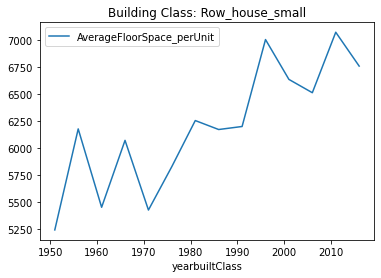

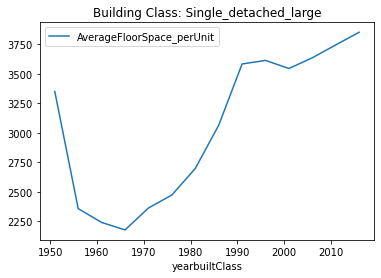

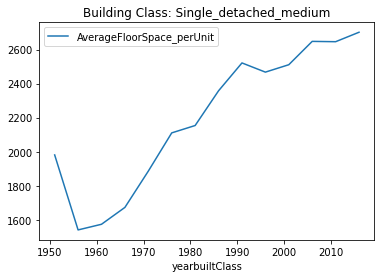

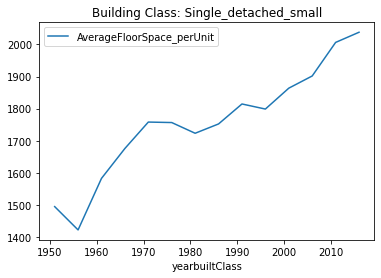

In [41]:
# plot each dwelling over time
plt.figure()
for i in range(len(dwelling)):
  data = dwelling[i] 
  name = data.buildingClass.iloc[0]
  ax = data.plot(x='yearbuiltClass',y='AverageFloorSpace_perUnit')
  ax.set_title('Building Class: {}'.format(name));
plt.show();
    

In [ ]:


# find weighted overall average dwelling size for each year

j=5

total = dwelling[j].TotalFloorSpc.sum()
dwelling[j]['weightedAve'] = (dwelling[j].TotalFloorSpc*dwelling[j].AverageFloorSpace_perUnit)/total
yrs = []
ave = []
      
      yrs.append(dwelling[j].yearbuiltClass.mean())
      ave.append(dwelling[j].weightedAve.sum())


# Plot Weighted Average
fig,ax = plt.subplots(1)
ax.plot(yrs[1:14] ,ave[1:14]);
ax.set_title('All Building Types, Weighted Average Floor Space per dwelling unit');
plt.show();

 

In [ ]:
# for each year, what is average floorSpcPerUnit ? (total floorspace divided by total numUnits)
overall = df[['buildingClass','yearbuiltClass','floorSpc_sf','numUnits']].groupby('yearbuiltClass').sum()
overall['averageFloorSpc_sf'] = overall['floorSpc_sf']/overall['numUnits']

# weighted average by Building Class each year
